In [44]:
#==================================================================
#Program: SLADS_TensorFlow
#Author(s): David Helminiak
#Date Created: 13 February 2019
#Date Last Modified: May 2019
#Changelog: 0.1  - Migration,Integration for cont. values - Sept. 2019
#
#==================================================================

#==================================================================
#ADDITIONAL NOTES:
#==================================================================
#Add Breakpoint anywhere in the program: 
#Tracer()()
#
#==================================================================

#==================================================================
#LIBRARY IMPORTS
#==================================================================
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
import math
import natsort
import os
import re
import shutil
import sys
import time
import netCDF4
from IPython.core.debugger import Tracer
#==================================================================


In [45]:
#==================================================================
#CLASS AND FUNCTION DEFINITIONS
#==================================================================

#Object to hold sample data
class dataObject:
    def __init__(self, name, data, medianLabels, rangeLabels):
        self.name = name
        self.data = data
        self.medianLables = medianLabels
        self.mzRangeLabels = rangeLabels
        
#Object to hold matching input and output data
class trainingDataObject:
    def __init__(self, inputData, outputData):
        self.inputData = inputData
        self.outputData = outputData

        
def cls(): #Clear console screen
    os.system('cls' if os.name=='nt' else 'clear')   

#==================================================================


In [46]:
#MAIN PROGRAM
#==================================================================
cls() #Clear the screen

#GENERAL PARAMETERS: L-01
#==================================================================
#Is training of a model to be performed
trainingModel = True

#Is testing of a model to be performed
testingModel = False

#What should the delta be between considered mz regions
mzDelta = 10

#How should mz regions of interest be filtered out
#Options: aboveAverage, topXValues, none
mzSelection = 'aboveAverage'

#If topXValues is being used for mzSelection, how many should be selected
topXValues = 10


#==================================================================

#STATIC VARIABLE SETUP
#==================================================================

#Create new blank tensorflow model here


#PATH/DIRECTORY SETUP
#==================================================================
dir_ResultsAndData = '.' + os.path.sep + 'ResultsAndData' + os.path.sep
dir_InputData = dir_ResultsAndData + 'InputData' + os.path.sep

dir_TrainingData = dir_InputData + 'TrainingData' + os.path.sep
dir_TestingData = dir_InputData + 'TestingData' + os.path.sep

dir_Results = dir_ResultsAndData + 'Results' + os.path.sep
dir_TrainingResults = dir_Results + 'TrainingResults' + os.path.sep
dir_TrainingResultsImages = dir_TrainingResults + 'Images' + os.path.sep
dir_TestingResults = dir_Results + 'TestingResults' + os.path.sep

#Check general directory structure
if not os.path.exists(dir_ResultsAndData):
    sys.exit('Error - dir_ResultsAndData does not exist')

#Input data directories
if not os.path.exists(dir_InputData):
    sys.exit('Error - dir_InputData does not exist')
if not os.path.exists(dir_TrainingData) and trainingModel:
    sys.exit('Error - dir_TrainingData does not exist')
if not os.path.exists(dir_TestingData) and testingModel:
    sys.exit('Error - dir_InputData does not exist')

#Results directories - reset results folders for new runs
if not os.path.exists(dir_Results):
    sys.exit('Error - dir_Results does not exist')
if trainingModel:
    if os.path.exists(dir_TrainingResults):
        shutil.rmtree(dir_TrainingResults)
    os.makedirs(dir_TrainingResults)
    os.makedirs(dir_TrainingResultsImages)    
    
if testingModel:
    if os.path.exists(dir_TestingResults):
        shutil.rmtree(dir_TestingResults)    
    os.makedirs(dir_TestingResults)

    

In [47]:
#DATA IMPORTATION
#==================================================================

trainingDataSamples = []
#For each of the samples intended for use in training
for trainingSampleFolder in glob.glob(dir_TrainingData + '/*'):
    dataSampleName = os.path.basename(trainingSampleFolder)
    print(dataSampleName)
    totalmzValuesArr = []
    totalIntensityValuesArr = []
    numPixelsArr = []
    minmz = None
    maxmz = None
    
    #For each of the line measurement files
    for fileName in natsort.natsorted(glob.glob(trainingSampleFolder + '/*.cdf'),reverse=False):
        
        #lineNumber = re.search('-line(\d+)', os.path.basename(fileName), re.IGNORECASE).group(1)
        file = netCDF4.Dataset(fileName)
        numPixels = len(file.variables['point_count'])
        numPixelsArr.append(numPixels)
        massValueData = file.variables['mass_values'][:].data
        ptrStart = 0

        #Determine the max and min mz values
        lineMinmz, lineMaxmz = np.min(massValueData), np.max(massValueData)
        if minmz == None and maxmz == None: minmz, maxmz = lineMinmz, lineMaxmz
        if lineMinmz < minmz: minmz = lineMinmz
        if lineMaxmz > maxmz: maxmz = lineMaxmz
        
        #For each of the pixels scanned, extract relevent data
        mzValuesArr = []
        IntensityValuesArr = []
        for pixelNum in range(0,numPixels):
            numMeasurements = file.variables['point_count'][pixelNum].data.item(0)
            mzValuesArr.append(massValueData[ptrStart:ptrStart+numMeasurements])
            IntensityValuesArr.append(file.variables['intensity_values'][ptrStart:ptrStart+numMeasurements].data)
            ptrStart += numMeasurements
        totalmzValuesArr.append(mzValuesArr)
        totalIntensityValuesArr.append(IntensityValuesArr)
    
    #Determine the mz ranges for averaging intensity values
    mzPoints = np.linspace(minmz, maxmz, int((maxmz-minmz)/mzDelta)+1)
    
    #Determine the average intensities for each pixel across the mz delta range specified
    medianLabels = []
    rangeLabels = []
    totalIntensitiesAvgArr = []
    for i in np.arange(0,len(mzPoints)-1,1):
        print('  ',(i/(len(mzPoints)-1))*100)
        rangeLabels.append([mzPoints[i],mzPoints[i+1]])
        medianLabels.append(mzPoints[i]+((mzPoints[i+1]-mzPoints[i])/2))
        intensitiesAvgArr = np.empty((len(totalIntensityValuesArr),np.max(numPixelsArr)))
        intensitiesAvgArr.fill(np.nan)
        for lineNum in range(0,len(totalmzValuesArr)):
            for columnNum in range(0,numPixelsArr[lineNum]):
                idx = np.argwhere(np.logical_and(totalmzValuesArr[lineNum][columnNum] >= mzPoints[i], totalmzValuesArr[lineNum][columnNum] <= mzPoints[i+1])).flatten().tolist()
                intensityValues = totalIntensityValuesArr[lineNum][columnNum][idx]
                if len(intensityValues > 0): intensitiesAvgArr[lineNum][columnNum] = np.mean(intensityValues)
        totalIntensitiesAvgArr.append(intensitiesAvgArr)
        
    #Determine the number of non-nan values in each of the intensity arrays, i.e. minimal interest
    nonNanValues = []
    #NOTE SHOULD BE ABLE TO VECTORIZE THIS NEXT LINE
    for i in range(0,len(totalIntensitiesAvgArr)): nonNanValues.append(np.sum(np.invert(np.isnan(np.asarray(totalIntensitiesAvgArr[i]).flatten()))))

    if mzSelection == 'topXValues':
        idx = [np.argpartition(np.asarray(nonNanValues), -topXValues)[-topXValues:]]
    elif mzSelection == 'aboveAverage':
        idx = np.where(np.asarray(nonNanValues) >= np.mean(nonNanValues))[0].tolist()
    
    #Filter out minimal interest mz regions if needed
    if mzSelection != 'None':
        totalIntensitiesAvgArr = np.asarray(totalIntensitiesAvgArr)[idx]
        medianLabels = np.asarray(medianLabels)[idx]
        rangeLabels = np.asarray(rangeLabels)[idx]

    #Output images here for debug purposes
    for i in range(0,len(totalIntensitiesAvgArr)):       
        plt.figure(figsize=(8,8))
        plt.imshow(np.nan_to_num(totalIntensitiesAvgArr[i]).tolist(),'hot',aspect='auto')
        plt.savefig(dir_TrainingResultsImages + 'fn_' + dataSampleName + '_mz_' + str(rangeLabels[i][0]) + '-' + str(rangeLabels[i][1]) + '_cmap_hot.png')
        plt.close()
        
    trainingDataSamples.append(dataObject(dataSampleName, intensitiesAvgArr, medianLabels, rangeLabels))
    


104-1-1
   0.0
   0.5319148936170213
   1.0638297872340425
   1.5957446808510638
   2.127659574468085
   2.6595744680851063
   3.1914893617021276
   3.723404255319149
   4.25531914893617
   4.787234042553192
   5.319148936170213
   5.851063829787234
   6.382978723404255
   6.914893617021277
   7.446808510638298
   7.9787234042553195
   8.51063829787234
   9.042553191489363
   9.574468085106384
   10.106382978723403
   10.638297872340425
   11.170212765957446
   11.702127659574469
   12.23404255319149
   12.76595744680851
   13.297872340425531
   13.829787234042554
   14.361702127659576
   14.893617021276595
   15.425531914893616
   15.957446808510639
   16.48936170212766
   17.02127659574468
   17.5531914893617
   18.085106382978726
   18.617021276595743
   19.148936170212767
   19.680851063829788
   20.212765957446805
   20.74468085106383
   21.27659574468085
   21.808510638297875
   22.340425531914892
   22.872340425531913
   23.404255319148938
   23.93617021276596
   24.468085106382

   8.51063829787234
   9.042553191489363
   9.574468085106384
   10.106382978723403
   10.638297872340425
   11.170212765957446
   11.702127659574469
   12.23404255319149
   12.76595744680851
   13.297872340425531
   13.829787234042554
   14.361702127659576
   14.893617021276595
   15.425531914893616
   15.957446808510639
   16.48936170212766
   17.02127659574468
   17.5531914893617
   18.085106382978726
   18.617021276595743
   19.148936170212767
   19.680851063829788
   20.212765957446805
   20.74468085106383
   21.27659574468085
   21.808510638297875
   22.340425531914892
   22.872340425531913
   23.404255319148938
   23.93617021276596
   24.46808510638298
   25.0
   25.53191489361702
   26.063829787234045
   26.595744680851062
   27.127659574468083
   27.659574468085108
   28.191489361702125
   28.723404255319153
   29.25531914893617
   29.78723404255319
   30.319148936170215
   30.851063829787233
   31.382978723404253
   31.914893617021278
   32.4468085106383
   32.97872340425532


   16.48936170212766
   17.02127659574468
   17.5531914893617
   18.085106382978726
   18.617021276595743
   19.148936170212767
   19.680851063829788
   20.212765957446805
   20.74468085106383
   21.27659574468085
   21.808510638297875
   22.340425531914892
   22.872340425531913
   23.404255319148938
   23.93617021276596
   24.46808510638298
   25.0
   25.53191489361702
   26.063829787234045
   26.595744680851062
   27.127659574468083
   27.659574468085108
   28.191489361702125
   28.723404255319153
   29.25531914893617
   29.78723404255319
   30.319148936170215
   30.851063829787233
   31.382978723404253
   31.914893617021278
   32.4468085106383
   32.97872340425532
   33.51063829787234
   34.04255319148936
   34.57446808510639
   35.1063829787234
   35.638297872340424
   36.17021276595745
   36.702127659574465
   37.234042553191486
   37.765957446808514
   38.297872340425535
   38.82978723404255
   39.361702127659576
   39.8936170212766
   40.42553191489361
   40.95744680851064
   41

   24.46808510638298
   25.0
   25.53191489361702
   26.063829787234045
   26.595744680851062
   27.127659574468083
   27.659574468085108
   28.191489361702125
   28.723404255319153
   29.25531914893617
   29.78723404255319
   30.319148936170215
   30.851063829787233
   31.382978723404253
   31.914893617021278
   32.4468085106383
   32.97872340425532
   33.51063829787234
   34.04255319148936
   34.57446808510639
   35.1063829787234
   35.638297872340424
   36.17021276595745
   36.702127659574465
   37.234042553191486
   37.765957446808514
   38.297872340425535
   38.82978723404255
   39.361702127659576
   39.8936170212766
   40.42553191489361
   40.95744680851064
   41.48936170212766
   42.02127659574468
   42.5531914893617
   43.08510638297872
   43.61702127659575
   44.148936170212764
   44.680851063829785
   45.21276595744681
   45.744680851063826
   46.27659574468085
   46.808510638297875
   47.340425531914896
   47.87234042553192
   48.40425531914894
   48.93617021276596
   49.468

In [11]:
        totalmzValuesArr.append(mzValuesArr)
        totalIntensityValuesArr.append(IntensityValuesArr)

2008.466719846908

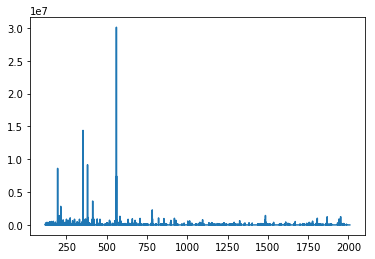

In [39]:

#For the first line, first pixel plot spectrum 
pixNum = 0
plt.plot(totalmzValuesArr[pixNum][0].tolist(), totalIntensityValuesArr[pixNum][0].tolist())

In [43]:
max(totalIntensityValuesArr[pixNum][0].tolist())

30097292

In [41]:
totalIntensityValuesArr[pixNum][0].tolist()

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 77639,
 112115,
 128294,
 112938,
 74860,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 79975,
 124063,
 143619,
 129130,
 88528,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 84518,
 108913,
 120549,
 101784,
 45605,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 66396,
 159989,
 249992,
 265788,
 193942,
 93722,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 96789,
 133097,
 205224,
 298509,
 306761,
 194330,
 66375,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 72908,
 105153,
 131508,
 132002,
 100773,
 51116,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 85620,
 107219,
 125242,
 119222,
 86473,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 54411,
 108128,
 155699,
 168489,
 124618,
 49493,
 0,
 0,
 0,
 0,
 94649,
 173620,
 217049,
 211231,
 229014,
 331907,
 398326,
 332276,
 177627,
 81262,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 60536,
 128151,
 165780,
 148963,
 88756,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 97041,
 121397,
 127939,
 112628,
 

In [ ]:
odict_keys(['error_log', 
            'instrument_name', 
            'instrument_id', 
            'instrument_mfr', 
            'instrument_model', 
            'instrument_sw_version', 
            'instrument_os_version', 
            'scan_index', 
            'point_count', 
            'flag_count', 
            'a_d_sampling_rate', 
            'scan_acquisition_time', 
            'scan_duration', 
            'mass_range_min', 
            'mass_range_max', 
            'scan_type', 
            'resolution', 
            'total_intensity', 
            'mass_values', 
            'intensity_values'])

In [ ]:
#STATIC VARIABLE SETUP
#==================================================================
#Create new blank tensorflow model



In [ ]:


#DATA IMPORTATION
#==================================================================
trainingSamples = []
for each of the folders inside of the training folder, import the names
    import the .mat files and create a 3D array
    
trainingData = []
for each of the training samples 
    linesToScan = []
    measuredPoints = []
    #Until all lines have been scanned once
    if first:
        select initial line
    else: 
        select partial line based on the erd
    inputData: mask data based on measuredPoints
    outputData, calculate full erd
    
    #Visualize the training data here if desired
    
    trainingData.append(new trainingDataObject(inputData, outputData))
    


#RUN TRAINING
#==================================================================  
print('\n\n\n\n\n' + ('-' * int(consoleColumns)))
print('PERFORM TRAINING')
print('-' * int(consoleColumns) + '\n')
    
    
#RUN TESTING
#==================================================================  
print('\n\n' + ('#' * int(consoleColumns)))
print('TESTING MODEL')
print(('#' * int(consoleColumns)) + '\n')

#PROGRAM COMPLETED
#==================================================================  
print('\n\n\n' + ('#' * int(consoleColumns)))
print('PROGRAM COMPLETE')
print('#' * int(consoleColumns) + '\n')